# Loading Data

In [1]:
from google.colab import files
uploads=files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Nov 19 14:15 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 245kB 6.0MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [6]:
!kaggle datasets download -d snap/amazon-fine-food-reviews
#!kaggle competitions download -c tgs-salt-identification-challenge

100% 250M/251M [00:02<00:00, 85.2MB/s]
100% 251M/251M [00:02<00:00, 113MB/s] 


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("amazon-fine-food-reviews.zip", 'r')
zip_ref.extractall("amazon")
zip_ref.close()

In [0]:
!pip install gensim

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle






#Data Preprocessing

In [0]:
con = sqlite3.connect('amazon/database.sqlite') 

In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

In [0]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [0]:
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [14]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [17]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [18]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [19]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [21]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [22]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [0]:
final.sort_values(by='Time',inplace=True)

In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence)
    
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [28]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [0]:
X=final_data['CleanedText']
y=final_data['Score']
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [0]:
final_data=final.head(10**5)

In [0]:
length=[]
for sent in final['Text']:
  length.append(len(sent))

In [0]:
final['len_text']=length

In [0]:
final_data['CleanedText'].to_pickle('CleanedText')

In [0]:
train_data=final_data.head(60000)
#cv_data=final_data[60000:80000]
test_data=final_data[60000:100000]


In [69]:
train_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,len_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,375
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,407
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,166
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,222
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,244


In [34]:
test_data.shape

(40000, 11)

In [0]:
def transform(x):
  if x=='positive':
    return 1
  else:
    return -1

In [0]:
y_=train_data['Score'].apply(transform)
y_test=test_data['Score'].apply(transform)
y_train=np.array(y_)
y_test=np.array(y_test)

In [37]:
y_.value_counts()

 1    53147
-1     6853
Name: Score, dtype: int64

In [38]:
a=53147
b=6853
print(a/(a+b))
print(b/(a+b))

0.8857833333333334
0.11421666666666666


# Bag of Words

In [0]:
count_vect = CountVectorizer()
bag_of_words = count_vect.fit_transform(train_data['CleanedText'].values)
print("the type of count vectorizer ",type(bag_of_words))
print("the shape of out text BOW vectorizer ",bag_of_words.get_shape())
print("the number of unique words ", bag_of_words.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 29132)
the number of unique words  29132


In [0]:
test_bag_of_words=count_vect.transform(test_data['CleanedText'])

In [0]:
X_train_1=bag_of_words
X_test_1=test_bag_of_words

In [0]:
X_train_1.shape

(60000, 29132)

In [0]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
clf=SGDClassifier()
tuned_parameters = {'penalty': ['none', 'l2', 'l1', 'elasticnet']}

model = GridSearchCV(clf, tuned_parameters, scoring = 'f1_weighted', cv=2,n_jobs=1)
model.fit(X_train_1, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['none', 'l2', 'l1', 'elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=0)

In [0]:
print(model.best_estimator_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [0]:
model.grid_scores_

[mean: 0.90728, std: 0.00229, params: {'penalty': 'none'},
 mean: 0.90960, std: 0.00251, params: {'penalty': 'l2'},
 mean: 0.90650, std: 0.00271, params: {'penalty': 'l1'},
 mean: 0.91139, std: 0.00038, params: {'penalty': 'elasticnet'}]

In [0]:
clf=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
clf.fit(X_train_1, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [0]:

y_pred=clf.predict(X_test_1)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 3202,  2216],
       [ 1141, 33441]])

In [0]:
from sklearn import metrics


In [0]:
metrics.f1_score(y_test,y_pred)

0.9522060393798317

In [0]:
coef=(clf.coef_).flatten()

In [0]:
coef=(clf.coef_).flatten()
coef1=[abs(x) for x in coef]



In [0]:
indeces_weights=np.array(coef1).argsort()
weights=np.take(coef,indeces_weights[-40:])


In [0]:
sign=[]
for val in weights:
  if val>0:
    sign.append("+")
  else:
    sign.append("-")

In [0]:
importent_features=np.take(count_vect.get_feature_names(),indeces_weights[-40:])

In [0]:

positive_features=[]
negative_features=[]
for i,val in enumerate(sign):
  if val=="+":
    positive_features.append(importent_features[i])
  else:
    negative_features.append(importent_features[i])

**Importent Positive & Negative Features**

In [0]:
print("Importent Positive Features")
print(positive_features)
print("Importent Negative Features")
print(negative_features)

Importent Positive Features
['excel', 'happi', 'often', 'beauti', 'downsid', 'hook', 'awesom', 'skeptic', 'smooth', 'uniqu', 'amaz', 'solv', 'best', 'perfect']
Importent Negative Features
['remot', 'stale', 'ined', 'weak', 'sad', 'flavorless', 'cancel', 'ugh', 'deceiv', 'disgust', 'return', 'mislead', 'unfortun', 'dissapoint', 'sorri', 'unpleas', 'wors', 'terribl', 'tasteless', 'aw', 'yuck', 'horribl', 'bland', 'disappoint', 'threw', 'worst']


In [0]:
tuned_parameters = {'C': [10**-4,10**-2, 10**2,10**4],'gamma':[10**-5,1,10**-3]}
clf=SVC(kernel='rbf')
model = GridSearchCV(clf, tuned_parameters, scoring = 'f1', cv=2,n_jobs=1)
model.fit(X_train_1, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.01, 100, 10000], 'gamma': [1e-05, 1, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [0]:
model.grid_scores_

[mean: 0.93943, std: 0.00001, params: {'C': 0.0001, 'gamma': 1e-05},
 mean: 0.93943, std: 0.00001, params: {'C': 0.0001, 'gamma': 1},
 mean: 0.93943, std: 0.00001, params: {'C': 0.0001, 'gamma': 0.001},
 mean: 0.93943, std: 0.00001, params: {'C': 0.01, 'gamma': 1e-05},
 mean: 0.93943, std: 0.00001, params: {'C': 0.01, 'gamma': 1},
 mean: 0.93943, std: 0.00001, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.94060, std: 0.00022, params: {'C': 100, 'gamma': 1e-05},
 mean: 0.93945, std: 0.00001, params: {'C': 100, 'gamma': 1},
 mean: 0.95702, std: 0.00037, params: {'C': 100, 'gamma': 0.001},
 mean: 0.95639, std: 0.00027, params: {'C': 10000, 'gamma': 1e-05},
 mean: 0.93945, std: 0.00001, params: {'C': 10000, 'gamma': 1},
 mean: 0.94264, std: 0.00247, params: {'C': 10000, 'gamma': 0.001}]

In [0]:
type(model.grid_scores_)

list

In [0]:
std=[[0.00001,0.00001,0.00001],[0.00001,0.00001,0.00001],[0.00022,0.00001,0.00037],[0.00027,0.00001,0.00247]]
std=np.array(std)
std

array([[1.00e-05, 1.00e-05, 1.00e-05],
       [1.00e-05, 1.00e-05, 1.00e-05],
       [2.20e-04, 1.00e-05, 3.70e-04],
       [2.70e-04, 1.00e-05, 2.47e-03]])

In [0]:
model.c

0.9394327732455999

In [0]:
from sklearn.metrics import confusion_matrix
mat=[[0.93943, 0.93943, 0.93943],[0.93943, 0.93943, 0.93943],[0.94060, 0.93945, 0.95702],[0.95639, 0.93945, 0.93945]]

  

In [0]:
mat=np.array(mat)

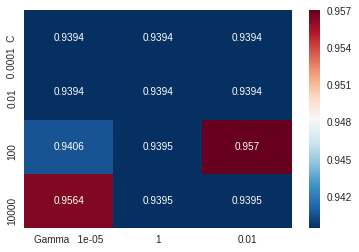

In [0]:
sns.heatmap(mat,annot=True,xticklabels=['Gamma   1e-05',1,0.01],yticklabels=[' 0.0001  C',0.01,100,10000],fmt='.4g',cmap='RdBu_r')

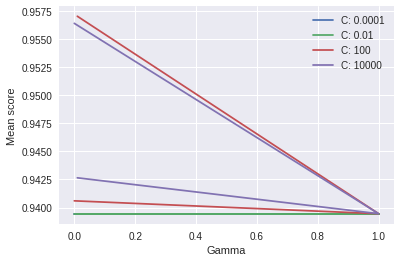

In [0]:
Gammas=  [ 1e-05,1,0.01]
Cs=[ 0.0001,0.01,100,10000]
scores = [x[1] for x in model.grid_scores_]
scores = np.array(scores).reshape(len(Cs), len(Gammas))

for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='C: ' + str(i))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.show()

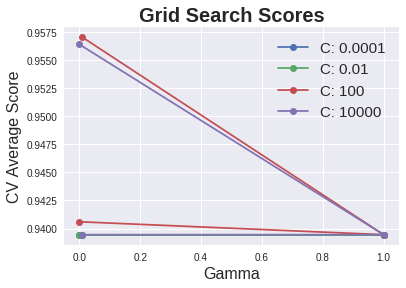

In [0]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):

    scores_mean=mat
    scores_sd=std

    _, ax = plt.subplots(1,1)

    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

plot_grid_search(model.grid_scores_, [1e-05,1,0.01],[0.0001,0.01,100,10000],'Gamma','C')

In [0]:
print(model.best_estimator_)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
model.grid_scores_

In [0]:
print(model.score(X_test_1, y_test))

0.9520039169056447


In [0]:
svc=SVC(C=100,gamma=0.0001,kernel='rbf')
svc.fit(X_train_1,y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:

y_pred=svc.predict(X_test_1)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 2542,  2876],
       [  555, 34027]])

In [0]:
clf=SVC()
C=np.random.uniform(10**-2,10**2,size=5)
gamma=np.random.uniform(10**-5,10**-2,size=2)
hyperparameters = dict(C=C,gamma=gamma)
model = RandomizedSearchCV(clf,param_distributions=hyperparameters, refit=True,scoring ='f1', cv=2,n_jobs=1)
model.fit(X_train_1, y_train)

RandomizedSearchCV(cv=2, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': array([34.44833, 98.89917,  5.67589,  4.28538, 69.89047]), 'gamma': array([0.00389, 0.00081])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [0]:
print(model.best_estimator_)

SVC(C=5.675885492967225, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0038900826290140873,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [0]:
svc=SVC(C=5.675885492967225,gamma=0.0038900826290140873,kernel='rbf')
svc.fit(X_train_1,y_train)

SVC(C=5.675885492967225, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0038900826290140873,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred=svc.predict(X_test_1)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 2853,  2565],
       [  646, 33936]])

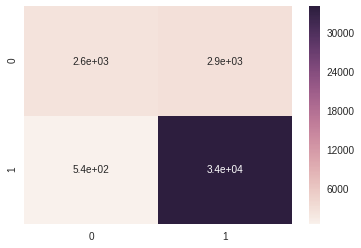

In [0]:
sns.heatmap(cm,annot=True)

#TF-IDF

In [88]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(train_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 815007)
the number of unique words including both unigrams and bigrams  815007


In [89]:
test_final_tf_idf=tf_idf_vect.transform(test_data['CleanedText'])

test_final_tf_idf.get_shape()

(40000, 815007)

In [0]:
X_train_2=final_tf_idf
X_test_2=test_final_tf_idf

In [0]:
clf=SGDClassifier()
tuned_parameters = {'penalty': ['none', 'l2', 'l1', 'elasticnet']}

model = GridSearchCV(clf, tuned_parameters, scoring = 'f1_weighted', cv=2,n_jobs=1)
model.fit(X_train_2, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['none', 'l2', 'l1', 'elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=0)

In [0]:
print(model.best_estimator_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [0]:
model.grid_scores_

[mean: 0.92326, std: 0.00212, params: {'penalty': 'none'},
 mean: 0.85534, std: 0.00241, params: {'penalty': 'l2'},
 mean: 0.85350, std: 0.00203, params: {'penalty': 'l1'},
 mean: 0.84205, std: 0.00119, params: {'penalty': 'elasticnet'}]

In [0]:
tfidf_clf= SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
tfidf_clf.fit(X_train_2, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [0]:
y_pred=tfidf_clf.predict(X_test_2)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 3316,  2102],
       [  849, 33733]])

In [0]:
metrics.f1_score(y_test,y_pred)

0.9580925060709772

In [0]:
coef=tfidf_clf.coef_.flatten()

In [0]:
coef1=[abs(x) for x in coef]
indeces_weights=np.array(coef1).argsort()

weights=np.take(coef,indeces_weights[-40:])

sign=[]
for val in weights:
  if val>0:
    sign.append("+")
  else:
    sign.append("-")

In [0]:

importent_features=np.take(tf_idf_vect.get_feature_names(),indeces_weights[-40:])

positive_features=[]
negative_features=[]
for i,val in enumerate(sign):
  if val=="+":
    positive_features.append(importent_features[i])
  else:
    negative_features.append(importent_features[i])

In [0]:
print("Importent Positive Features")
print(positive_features)
print("Importent Negative Features")
print(negative_features)

Importent Positive Features
['keep', 'happi', 'satisfi', 'favorit', 'awesom', 'wonder', 'tasti', 'ladyfing', 'good', 'amaz', 'nice', 'excel', 'perfect', 'love', 'delici', 'best', 'great']
Importent Negative Features
['ined', 'money', 'wors', 'wast', 'yuck', 'cancel', 'unpleas', 'wast money', 'sorri', 'threw', 'wont buy', 'mayb', 'weak', 'stale', 'horribl', 'aw', 'refund', 'return', 'bland', 'unfortun', 'terribl', 'worst', 'disappoint']


In [0]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [0]:
tuned_parameters = {'C': [0.0001,0.01,100,10000],'gamma':[1e-05,1,0.01]}
clf=SVC(kernel='rbf')
model = GridSearchCV(clf, tuned_parameters, scoring = 'f1', cv=2,n_jobs=1)
model.fit(X_train_2, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 100], 'gamma': [0.0001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [0]:
tf_idf_scores=model.grid_scores_

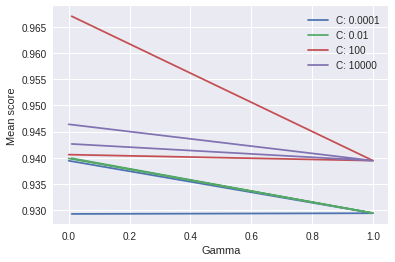

In [0]:
Gammas=  [ 1e-05,1,0.01]
Cs=[ 0.0001,0.01,100,10000]
scores = [x[0] for x in tf_idf_scores]
scores = np.array(scores).reshape(len(Cs), len(Gammas))

for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='C: ' + str(i))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.show()

In [0]:
tf_idf_scores=model.grid_scores_

In [0]:
tf_idf_means=[]
for i,val in enumerate(tf_idf_scores):
  mean=tf_idf_scores[i][0]
  tf_idf_means.append(mean)

In [0]:

tf_idf_means=np.array(tf_idf_means).reshape(4,3)

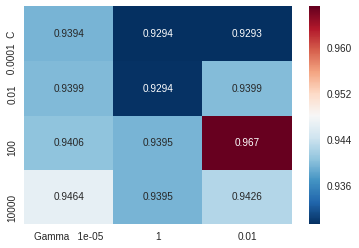

In [0]:
sns.heatmap(tf_idf_means,annot=True,xticklabels=['Gamma   1e-05',1,0.01],yticklabels=[' 0.0001  C',0.01,100,10000],fmt='.4g',cmap='RdBu_r')

In [0]:
print(model.best_estimator_)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
print(model.score(X_test_2, y_test))

0.9610190649114844


In [0]:
svc=SVC(C=100,gamma=0.01,kernel='rbf')
svc.fit(X_train_2,y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
y_pred=svc.predict(X_test_2)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 3378,  2040],
       [  708, 33874]])

In [0]:
clf=SVC()
C=np.random.uniform(10**-2,10**3,size=5)
gamma=np.random.uniform(10**-2,10**-1,size=2)
hyperparameters = dict(C=C,gamma=gamma)
model = RandomizedSearchCV(clf,param_distributions=hyperparameters, refit=True,scoring ='f1', cv=2,n_jobs=1)
model.fit(X_train_2, y_train)

RandomizedSearchCV(cv=2, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': array([388.18347, 491.84924, 737.86182, 523.21323, 982.11946]), 'gamma': array([0.04383, 0.09917])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [0]:
print(model.best_estimator_)

In [0]:
svc=SVC(C=388.18347,gamma=0.09917,kernel='rbf')
svc.fit(X_train_2,y_train)

SVC(C=388.18347, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.09917, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
y_pred=svc.predict(X_test_2)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 3347,  2071],
       [  703, 33879]])

[[ 3347  2071]
 [  703 33879]]


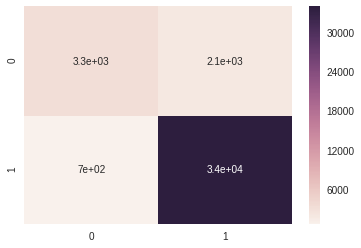

In [0]:
import seaborn as sns
print(cm)
sns.heatmap(cm,annot=True)

# Word to Vec

In [0]:
i=0
list_of_sent=[]
for sent in train_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [85]:
len(list_of_sent)

60000

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [87]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9957
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool']


# AVG WORD2VEC

In [0]:
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


In [0]:
test_list_of_sent=[]
for sent in test_data['CleanedText'].values:
    test_list_of_sent.append(sent.split())

In [0]:
test_sent_vectors = []
for sent in test_list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)

In [93]:
len(test_sent_vectors)

40000

In [0]:
X_train_3=np.array(sent_vectors)
X_test_3=np.array(test_sent_vectors)

In [95]:
clf=SGDClassifier()
tuned_parameters = {'penalty': ['none', 'l2', 'l1', 'elasticnet']}

model = GridSearchCV(clf, tuned_parameters, scoring = 'f1_weighted', cv=2,n_jobs=1)
model.fit(X_train_3, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['none', 'l2', 'l1', 'elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=0)

In [96]:
model.grid_scores_

[mean: 0.89095, std: 0.00469, params: {'penalty': 'none'},
 mean: 0.88443, std: 0.00863, params: {'penalty': 'l2'},
 mean: 0.88532, std: 0.00140, params: {'penalty': 'l1'},
 mean: 0.88049, std: 0.00252, params: {'penalty': 'elasticnet'}]

In [97]:
print(model.best_estimator_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [98]:
avg_clf=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
avg_clf.fit(X_train_3, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [99]:

y_pred=avg_clf.predict(X_test_3)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 1635,  3783],
       [  641, 33941]])

In [0]:
metrics.f1_score(y_test,y_pred)

0.9371148814045751

In [0]:
coef=(avg_clf.coef_).flatten()
coef1=[abs(x) for x in coef]
indeces_weights=np.array(coef1).argsort()
weights=np.take(coef,indeces_weights[-40:])
sign=[]
for val in weights:
  if val>0:
    sign.append("+")
  else:
    sign.append("-")
importent_features=np.take(coef,indeces_weights[-40:])
positive_features=[]
negative_features=[]
for i,val in enumerate(sign):
  if val=="+":
    positive_features.append(importent_features[i])
  else:
    negative_features.append(importent_features[i])


In [102]:
print(positive_features)

[0.15137937824550202, 0.22237976247809924, 0.22960475335868896, 0.23335346952217542, 0.31523805567970853, 0.3460905352363676, 0.3581624069956718, 0.3625531859228301, 0.4139624496781385, 0.4142197292994494, 0.43067685754630575, 0.4601603862717595, 0.4689971921439338, 0.5453170570654826, 0.7529062287566474, 0.8058766907629258, 0.8258958680429358, 0.8649187407966075, 1.014977037329138, 1.7893270473122336]


In [103]:
print(negative_features)

[-0.12168502713796124, -0.1534000241541942, -0.17281358652575077, -0.18131289338356338, -0.19262535722747565, -0.19296333230777948, -0.22804015253393772, -0.24302699861947055, -0.2558080696414516, -0.30233739972781665, -0.30467344812326036, -0.3452875529573827, -0.35707598394039497, -0.40470081006933445, -0.47452968124423217, -0.6479197206405627, -0.6569494152590861, -0.8841655996640662, -1.0251234610393656, -1.4031789715213578]


In [0]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [0]:
tuned_parameters = {'C': [10**-2, 10**2,10**3],'gamma':[10**-4,10**-2]}
clf=SVC(kernel='rbf')
model = GridSearchCV(clf, tuned_parameters, scoring = 'f1', cv=3,n_jobs=1)
model.fit(X_train_3, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 100, 1000], 'gamma': [0.0001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [0]:
print(model.best_estimator_)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
model.grid_scores_

[mean: 0.93943, std: 0.00001, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.93943, std: 0.00001, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.94046, std: 0.00135, params: {'C': 100, 'gamma': 0.0001},
 mean: 0.95233, std: 0.00085, params: {'C': 100, 'gamma': 0.01},
 mean: 0.94462, std: 0.00077, params: {'C': 1000, 'gamma': 0.0001},
 mean: 0.95075, std: 0.00115, params: {'C': 1000, 'gamma': 0.01}]

In [0]:
avg_scoresmodel.grid_scores_

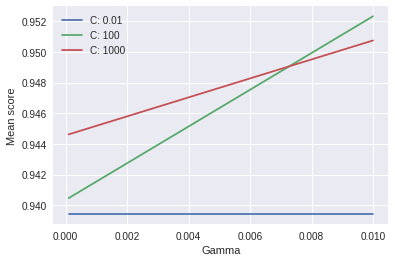

In [0]:
Gammas=  [10**-4,10**-2]
Cs=[10**-2, 10**2,10**3]
scores = [x[0] for x in avg_scores]
scores = np.array(scores).reshape(len(Cs), len(Gammas))

for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='C: ' + str(i))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.show()

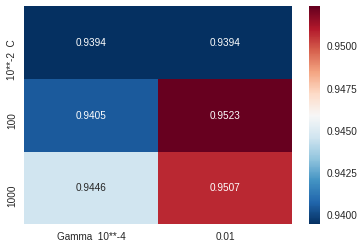

In [0]:
avg_means=[]
for i,val in enumerate(avg_scores):
  mean=avg_scores[i][0]
  avg_means.append(mean)
tf_idf_means=np.array(avg_means).reshape(3,2)
sns.heatmap(tf_idf_means,annot=True,xticklabels=['Gamma  10**-4',10**-2],yticklabels=['10**-2  C', 10**2,10**3],fmt='.4g',cmap='RdBu_r')

In [0]:
print(model.score(X_test_3, y_test))

0.9446879334257975


In [0]:
svc=SVC(C=100,gamma=0.01,kernel='rbf')
svc.fit(X_train_3,y_train)
y_pred=svc.predict(X_test_3)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 1980,  3438],
       [  526, 34056]])

In [0]:
clf=SVC()
C=np.random.uniform(10**-2,10**3,size=4)
gamma=np.random.uniform(10**-3,10**2,size=3)
hyperparameters = dict(C=C,gamma=gamma)
model = RandomizedSearchCV(clf,param_distributions=hyperparameters, refit=True,scoring ='f1', cv=3,n_jobs=1)
model.fit(X_train_3, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': array([ 98.56345, 326.44462, 766.11478, 149.50829]), 'gamma': array([73.04484, 91.5753 , 44.22699])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [0]:
model.grid_scores_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.93943, std: 0.00001, params: {'gamma': 91.57529951951626, 'C': 326.44461523559403},
 mean: 0.93943, std: 0.00001, params: {'gamma': 44.2269930953766, 'C': 326.44461523559403},
 mean: 0.93943, std: 0.00001, params: {'gamma': 73.04484138624902, 'C': 326.44461523559403},
 mean: 0.93943, std: 0.00001, params: {'gamma': 73.04484138624902, 'C': 766.1147790598457},
 mean: 0.93943, std: 0.00001, params: {'gamma': 44.2269930953766, 'C': 98.56345249302434},
 mean: 0.93943, std: 0.00001, params: {'gamma': 73.04484138624902, 'C': 149.50828832372733},
 mean: 0.93943, std: 0.00001, params: {'gamma': 91.57529951951626, 'C': 149.50828832372733},
 mean: 0.93943, std: 0.00001, params: {'gamma': 73.04484138624902, 'C': 98.56345249302434},
 mean: 0.93943, std: 0.00001, params: {'gamma': 91.57529951951626, 'C': 766.1147790598457},
 mean: 0.93943, std: 0.00001, params: {'gamma': 91.57529951951626, 'C': 98.56345249302434}]

In [0]:
print(model.best_estimator_)

SVC(C=326.44461523559403, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=91.57529951951626,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [0]:
svc=SVC(C=388.18347,gamma=0.091,kernel='rbf')
svc.fit(X_train_3,y_train)

SVC(C=388.18347, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.091, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
y_pred=svc.predict(X_test_3)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 2639,  2779],
       [ 2238, 32344]])

[[ 2639  2779]
 [ 2238 32344]]


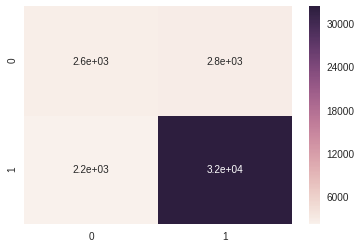

In [0]:

import seaborn as sns
print(cm)
sns.heatmap(cm,annot=True)

# TF-IDF Word2Vec

In [0]:
tfidf_feat = tf_idf_vect.get_feature_names()

In [0]:
tfidf_sent_vectors = []
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
           
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
  
    if  row%500==0:
      print(row)
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

**Tranforming Test Data**

In [0]:
test_tfidf_sent_vectors = []
row=0;
for sent in test_list_of_sent: 
    sent_vec = np.zeros(50)
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
           
            tf_idf = test_final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
  
    if  row%500==0:
      print(row)
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

In [42]:
uploads= files.upload()

Saving test_tfidf_sent_vectors to test_tfidf_sent_vectors


In [0]:
df1=pd.read_pickle("tfidf_sent")
df2=pd.read_pickle("cv_tfidf_sent_vectors")
df3=pd.read_pickle("test_tfidf_sent_vectors")

In [0]:
df4=df2.append(df3)
X_train_4=np.array(df1)
X_test_4=np.array(df4)


In [0]:
len_=np.array(train_data['len_text'])
len_test=np.array(test_data['len_text'])
X_test__4=np.vstack((X_test_4.T,len_test)).T
X_train__4=np.vstack((X_train_4.T,len_)).T

In [0]:
from sklearn.linear_model import SGDClassifier

In [74]:
clf=SGDClassifier()
tuned_parameters = {'penalty': ['none', 'l2', 'l1', 'elasticnet']}

model = GridSearchCV(clf, tuned_parameters, scoring = 'f1_weighted', cv=2,n_jobs=1)
model.fit(X_train__4, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['none', 'l2', 'l1', 'elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=0)

In [75]:
print(model.best_estimator_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [0]:
model.grid_scores_

[mean: 0.83196, std: 0.00007, params: {'penalty': 'none'},
 mean: 0.83213, std: 0.00001, params: {'penalty': 'l2'},
 mean: 0.78250, std: 0.04965, params: {'penalty': 'l1'},
 mean: 0.48408, std: 0.34520, params: {'penalty': 'elasticnet'}]

In [76]:
wti_clf=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
wti_clf.fit(X_train__4, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [0]:

y_pred=wti_clf.predict(X_test__4)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 1504,  3914],
       [ 8847, 25735]])

In [0]:
metrics.f1_score(y_test,y_pred)

0.8013264623001355

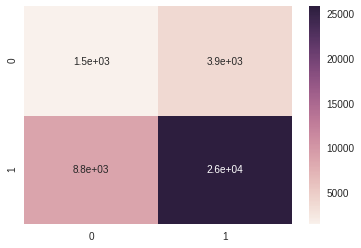

In [0]:
sns.heatmap(cm,annot=True)

In [0]:
coef=(wti_clf.coef_).flatten()
coef1=[abs(x) for x in coef]
indeces_weights=np.array(coef1).argsort()
weights=np.take(coef,indeces_weights[-40:])
sign=[]
for val in weights:
  if val>0:
    sign.append("+")
  else:
    sign.append("-")


In [0]:
importent_features=np.take(coef,indeces_weights[-40:])
positive_features=[]
negative_features=[]
for i,val in enumerate(sign):
  if val=="+":
    positive_features.append(importent_features[i])
  else:
    negative_features.append(importent_features[i])

In [80]:
print(positive_features)

[57.22326666881076, 59.66997068015463, 60.65987883105945, 65.28146966814263, 79.85690277546863, 94.1832235895287, 102.40023087113423, 113.58366795292646, 131.68640595980898, 136.89121417700318, 152.70142132558146, 169.43817307935566, 172.99121635944095, 174.30617368097754, 208.33210252219115, 224.01082396019854, 239.39086021198924, 239.6838619194495, 252.0628909299831, 298.4095603381215, 373.3187038382483]


In [83]:
print(negative_features)

[-53.85473565321225, -80.71673560049645, -100.3350982257555, -132.21240428062728, -137.54995368901498, -148.32702920307858, -159.64284189291214, -164.84465830060608, -165.64562094301806, -171.35007977492293, -187.04256317480596, -199.55042482984925, -241.67286352773945, -256.0759156588032, -278.15056097774993, -304.84625538957044, -334.3247263715209, -349.46150903437774, -399.4408550418526]


In [0]:
tuned_parameters = {'C': [10**-2, 10**3],'gamma':[10**-4,10**-2]}
clf=SVC(kernel='rbf')
model = GridSearchCV(clf, tuned_parameters, scoring = 'f1', cv=2,n_jobs=1)
model.fit(X_train_4, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 100, 1000], 'gamma': [0.0001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [0]:
tuned_parameters = {'C': [10**-2, 10**3],'gamma':[10**-4,10**-1]}
clf=SVC(kernel='rbf')
model = GridSearchCV(clf, tuned_parameters, scoring = 'f1', cv=2,n_jobs=1)
model.fit(X_train_4, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 1000], 'gamma': [0.0001, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [0]:
t_scores=model.grid_scores

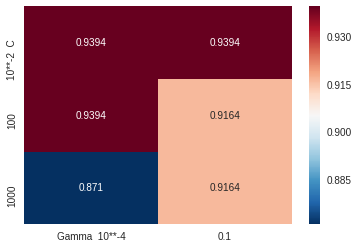

In [100]:
t_means=[]
for i,val in enumerate(t_scores):
  mean=t_scores[i][0]
  t_means.append(mean)
tf_idf_means=np.array(t_means).reshape(3,2)
sns.heatmap(tf_idf_means,annot=True,xticklabels=['Gamma  10**-4',10**-1],yticklabels=['10**-2  C', 10**2,10**3],fmt='.4g',cmap='RdBu_r')

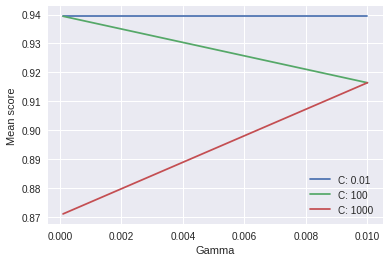

In [54]:
Gammas=  [10**-4,10**-2]
Cs=[10**-2, 10**2,10**3]
scores = [x[0] for x in t_scores]
scores = np.array(scores).reshape(len(Cs), len(Gammas))

for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='C: ' + str(i))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.show()

In [0]:
print(model.best_estimator_)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
model.grid_scores_

In [0]:
tuned_parameters = {'C': [10**-2, 10**3],'gamma':[10**-4,10**-2]}
clf=SVC(kernel='rbf')
model = GridSearchCV(clf, tuned_parameters, scoring = 'f1', cv=2,n_jobs=1)
model.fit(X_train_4, y_train)

In [0]:
clf=SVC()
C=np.random.uniform(10**-2,10**3,size=5)
gamma=np.random.uniform(10**-3,10**2,size=2)
hyperparameters = dict(C=C,gamma=gamma)
model = RandomizedSearchCV(clf,param_distributions=hyperparameters, refit=True,scoring ='f1', cv=2,n_jobs=1)
model.fit(X_train_4, y_train)

RandomizedSearchCV(cv=2, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': array([837.75415, 761.04913, 185.66889, 331.0065 ,   4.04939]), 'gamma': array([86.03765, 28.06075])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [0]:
print(model.best_estimator_)

SVC(C=837.7541512943137, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=86.03764760550023,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [0]:
y_pred=svc.predict(X_test_4)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

In [48]:
svc=SVC(C=1000,gamma=0.01,kernel='rbf')
svc.fit(X_train_4,y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
y_pred=svc.predict(X_test_4)
cm=confusion_matrix(y_test,y_pred)
print("CM ")
cm

CM 


array([[ 1460,  3958],
       [ 6473, 28109]])

In [52]:
print(metrics.f1_score(y_test,y_pred))

0.8434935257843327


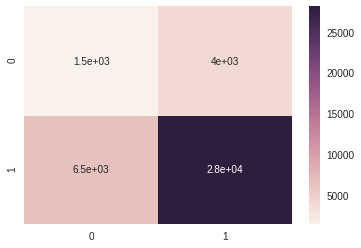

In [50]:
sns.heatmap(cm,annot=True)

In [0]:
!pip install prettytable
from prettytable import PrettyTable

#Conclusion

** RBF KERNEL**

In [58]:
x = PrettyTable()
x.field_names = ["Model", "Search","C","Gamma","Train Score( F1_score)", "Test Score"]
x.add_row(["Bag of words","GridSearch",100, 0.0001, 94.3 ,95.2])
x.add_row(["Bag of words","RandomSearch",5.67 ,0.00389, 94.98 ,95.88])
x.add_row(["TF_IDF","GridSearch",100 ,0.01, 94.23 ,96.101])
x.add_row(["TF_IDF","RandomSearch",388.18 ,0.099,94.23,95.8928])
x.add_row(["AVG-W2VEC","GridSearch",100, 0.01, 95.23, 91.26])
x.add_row(["AVG-W2VEC","RandomSearch",326.44,91.57,93.94,93.284])
x.add_row(["Weighted TF_IDF","GridSearch",1000,0.1,87.23,84.24])
x.add_row(["Weighted TF_IDF","RandomSearch",837.243,0.86,85.98,82.19])
print(x)


+-----------------+--------------+---------+---------+------------------------+------------+
|      Model      |    Search    |    C    |  Gamma  | Train Score( F1_score) | Test Score |
+-----------------+--------------+---------+---------+------------------------+------------+
|   Bag of words  |  GridSearch  |   100   |  0.0001 |          94.3          |    95.2    |
|   Bag of words  | RandomSearch |   5.67  | 0.00389 |         94.98          |   95.88    |
|      TF_IDF     |  GridSearch  |   100   |   0.01  |         94.23          |   96.101   |
|      TF_IDF     | RandomSearch |  388.18 |  0.099  |         94.23          |  95.8928   |
|    AVG-W2VEC    |  GridSearch  |   100   |   0.01  |         95.23          |   91.26    |
|    AVG-W2VEC    | RandomSearch |  326.44 |  91.57  |         93.94          |   93.284   |
| Weighted TF_IDF |  GridSearch  |   1000  |   0.1   |         87.23          |   84.24    |
| Weighted TF_IDF | RandomSearch | 837.243 |   0.86  |         85.98  

**Linear Kernal**

In [0]:
x = PrettyTable()
x.field_names = ["Model","Penalty","Train score( F1_score)", "Test Score"]
x.add_row(["Bag of words","elasicnet",91.11,95.22])
x.add_row(["TF_IDF","None",92.32,95.38])
x.add_row(["AVG-W2VEC","L2",88.23,93.71])
x.add_row(["Weighted TF_IDF","L2",83.23,80.13])
print(x)

+-----------------+-----------+------------------------+------------+
|      Model      |  Penalty  | Train score( F1_score) | Test Score |
+-----------------+-----------+------------------------+------------+
|   Bag of words  | elasicnet |         91.11          |   95.22    |
|      TF_IDF     |    None   |         92.32          |   95.38    |
|    AVG-W2VEC    |     L2    |         88.23          |   93.71    |
| Weighted TF_IDF |     L2    |         83.23          |   80.13    |
+-----------------+-----------+------------------------+------------+
